# Title

In [44]:
import itertools
import os

from tqdm import tqdm
import pandas as pd
import networkx as nx

from scripts.helpers import get_classification_from_json, get_embeddings_from_proba
from bokeh.plotting import figure, from_networkx, curdoc
from bokeh.models import (Circle, MultiLine, BasicTicker, CustomJS, NodesAndLinkedEdges,
                          RangeSlider, InlineStyleSheet, ColumnDataSource, Slope)

from scripts.plotting import plot_bokeh_graph, _get_rangeslider

In [5]:
root_path = os.path.dirname(os.path.abspath(""))

In [6]:
df = pd.read_csv(os.path.join(root_path, 'data/processed/preprocessed.csv'), index_col=0)
print(df.shape)
df.head(5)

(22394, 10)


,name,release_year,rating,num_votes,wikipedia_id,plot,freebase_id,languages,countries,genres
0,Miss Jerry,1894.0,5.3,207,10109752,After finding out that her father is suffering...,/m/02q23xk,['Silent film'],['United States of America'],"['Short Film', 'Silent film', 'Indie', 'Black-..."
1,The Corbett-Fitzsimmons Fight,1897.0,5.3,484,28703057,The film no longer exists in its entirety; how...,/m/0czdh_n,[],[],['Sports']
2,The Story of the Kelly Gang,1906.0,6.0,855,142995,The Story of the Kelly Gangs tone is of sorrow...,/m/0120y4,['English Language'],['Australia'],"['Crime Fiction', 'Silent film', 'Biography', ..."
3,Robbery Under Arms,1907.0,4.3,25,32986669,Key scenes of the film included the branding o...,/m/04p7yxx,['Silent film'],['Australia'],"['Silent film', 'Drama']"
4,"Captain Midnight, the Bush King",1911.0,5.4,18,32987200,Edgar Dalimore is the son of wealthy station o...,/m/0h569x9,['Silent film'],[],['Silent film']


In [7]:
decade = 1920
probabilities = get_classification_from_json(decade)

In [8]:
embeddings = get_embeddings_from_proba(probabilities)

In [9]:
# generate all possible combinations for dot product 
unique_movies = list(set(embeddings.keys()))
combinations = list(itertools.combinations(unique_movies, 2))

In [21]:
similarity_dict = {}

for movie_1, movie_2 in tqdm(combinations):
    similarity = embeddings[movie_1] @ embeddings[movie_2]
    similarity_dict[(str(movie_1), str(movie_2))] = similarity

100%|██████████| 85078/85078 [00:00<00:00, 380559.87it/s]


<AxesSubplot:title={'center':'Distribution of similarity values'}, ylabel='Frequency'>

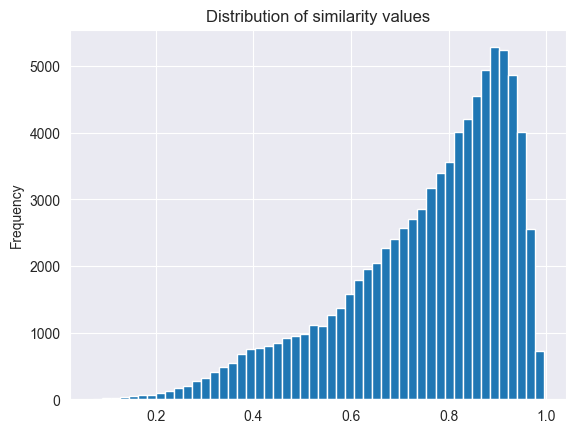

In [22]:
# check the distribution of similarity values
similarity_values = list(similarity_dict.values())
pd.Series(similarity_values).plot.hist(bins=50, title='Distribution of similarity values')

In [23]:
descriptive_stats = pd.Series(similarity_values).describe()
descriptive_stats

count    85078.000000
mean         0.754230
std          0.170501
min          0.070979
25%          0.657979
50%          0.798992
75%          0.888561
max          0.994460
dtype: float64

In [24]:
similarity_threshold = descriptive_stats['75%'] 

# generate nodes df and add all the pairs with similarity
similarity_mat = [[key[0], key[1], value] for key, value in similarity_dict.items()]
nodes_df = pd.DataFrame(similarity_mat, columns=['Source', 'Target', 'Weight']) 

# filter based on 75th percentile
nodes_df = nodes_df[nodes_df.Weight > similarity_threshold]

G = nx.from_pandas_edgelist(nodes_df, 'Source', 'Target', 'Weight')

In [25]:
G.number_of_nodes(), G.number_of_edges()

(409, 21270)

In [38]:
def add_features_from_df(graph, df: pd.DataFrame, features: list):
    graph_df = df.set_index('wikipedia_id')
    
    for feature in features:
        ratings_dict = dict((id_, graph_df.loc[int(id_)][feature]) for id_ in graph.nodes)
        nx.set_node_attributes(graph, name=feature, values=ratings_dict)

    return graph

features_from_df = ['name', 'rating', 'release_year']
G = add_features_from_df(G, df, features_from_df)

# add wikipedia id itself as an attribute
names = dict((id_, int(id_)) for id_ in G.nodes)
nx.set_node_attributes(G, name='wikipedia_id', values=names)

# calculate the betweenness centrality
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, name='betweenness', values=betweenness)

# calculate degree for each node
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

# adjusted node size 
adjusted_node_size = dict((key, value * 3.3) for key, value in nx.get_node_attributes(G, "rating").items())
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

mapping = dict((n, i) for i, n in enumerate(G.nodes))
G = nx.relabel_nodes(G, mapping)

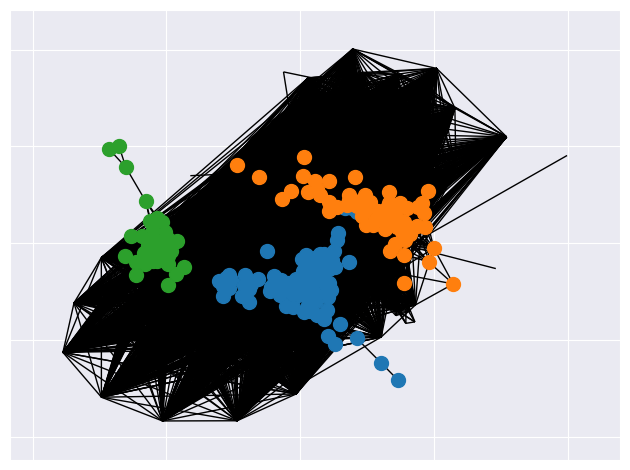

In [69]:
import matplotlib.pyplot as plt

communities = nx.community.greedy_modularity_communities(G, cutoff=6, best_n=10, resolution=4)

# supergraph using a larger scale factor
supergraph = nx.cycle_graph(len(communities))
superpos = nx.spring_layout(G, scale=50, seed=429)

# Use the "supernode" positions as the center of each node cluster
centers = list(superpos.values())
pos = {}
for center, comm in zip(centers, communities):
    pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center, seed=1430))
    
# Nodes colored by cluster
for nodes, clr in zip(communities, ("tab:blue", "tab:orange", "tab:green")):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_color=clr, node_size=100)
nx.draw_networkx_edges(G, pos=pos)
    
plt.tight_layout()
plt.show()

In [70]:
from scripts.plotting import _generate_plottable_graph
from bokeh.transform import linear_cmap
from bokeh.palettes import cividis, viridis
from bokeh.layouts import column
from networkx.classes.graph import Graph

def plot_bokeh_graph(
        graph,
        color_attribute: str = 'degree',
        size_attribute: str = 'adjusted_node_size',
        position = None,
        layout = nx.spring_layout,
        **figure_kwargs
):
    """
    Plot bokeh graph with stylized nodes and slider with IMDB ratings.

    :param graph: networkx instance
    :param color_attribute: attribute of graph that will be used for coloring the nodes
    :param size_attribute: attribute of graph that will be used for sizing the nodes
    :param figure_kwargs: {sizing_mode: 'stretch_both'} for website
    :return: bokeh plot
    """
    curdoc().theme = 'light_minimal'
    color_palette = viridis(256)

    # establish which categories will appear when hovering over each node
    tooltips = [
        ("Name", "@name"),
        ("Release year", "@release_year"),
        ("Rating", "@rating{0.0}"),
        ("Degree", "@degree{0}"),
        ("Betweenness", "@betweenness{0.0000}"),
    ]

    # create a plot — set dimensions, toolbar, and title
    plot = figure(
        tooltips=tooltips,
        toolbar_location=None,
        tools="pan,wheel_zoom,tap",
        active_scroll='wheel_zoom',
        **figure_kwargs
    )

    plot.axis.visible = False
    plot.grid.visible = False
    plot.outline_line_color = None

    # create a network graph object with spring layout
    bokeh_graph = from_networkx(graph, pos, scale=10)

    # set node sizes and colors according to node degree (color as spectrum of color palette)
    node_attributes = bokeh_graph.node_renderer.data_source.data
    attribute = node_attributes[color_attribute]
    colormap = linear_cmap(color_attribute, color_palette, min(attribute), max(attribute))

    bokeh_graph.node_renderer.glyph = Circle(size=size_attribute, fill_color=colormap)

    # set edge opacity and width
    bokeh_graph.edge_renderer.glyph = MultiLine(
        line_alpha=0.3, line_width=1, line_color="#CCCCCC"
    )
    bokeh_graph.edge_renderer.selection_glyph = MultiLine(
        line_alpha=1, line_width=1.3, line_color="#F0610F"
    )

    bokeh_graph.selection_policy = NodesAndLinkedEdges()
    bokeh_graph.inspection_policy = NodesAndLinkedEdges()

    # add network graph to the plot
    plot.renderers.append(bokeh_graph)

    widget = _get_rangeslider(bokeh_graph)

    custom_css = ".bk-RangeSlider { margin-left: auto; margin-right: auto }"
    stylesheet = InlineStyleSheet(css=custom_css)

    # Create a layout with the plot and the slider
    return column(widget, plot, sizing_mode='stretch_width', height=700, stylesheets=[stylesheet])

In [71]:
from bokeh.io import show

 
layout = plot_bokeh_graph(G, color_attribute='betweenness', position=pos, sizing_mode='stretch_width', height=700)
show(layout)

In [48]:
pos

{390: [0.6176770430891656, -1.370732283596819],
 391: [0.6155317556491273, -1.4353615683516432],
 398: [0.2117889804244529, -1.6188070780514325],
 402: [0.5322821287836474, -1.2463081254413721],
 404: [0.43870951965371024, -2.0050707698184356],
 277: [-0.21416415087165083, -1.0954092787444885],
 405: [0.3459671411398763, -2.041935436258276],
 406: [0.40098252050397076, -2.048812502675625],
 282: [-0.5244189065119171, -1.0661053350780254],
 283: [-0.6176903190864702, -1.0626304506707176],
 284: [-0.3846374924601033, -1.189622861131667],
 285: [-0.32739104125814933, -1.1571119039288509],
 288: [-0.8537608906749596, -1.683195472573486],
 289: [-0.6313400142903262, -1.4701152416399055],
 290: [-0.9957527400444954, -1.8476930039810677],
 291: [0.31551400433821186, -1.3898411568351947],
 293: [0.3090574426444954, -1.3308138044038569],
 297: [-0.18359551824954082, -1.2331254981121988],
 298: [-0.10270302854288839, -1.3676641535370253],
 300: [-0.08248177661304194, -1.0962327763517374],
 301: 